In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import denmatsim.simulator as sim
import numpy as np
from matplotlib import pyplot as plt

## Quick tests using the underlying simulator code directly

In [4]:
# Define spin system and field strength 
spinsys = {'shifts':np.array([0,2, -2]),'j':np.array([[0,0,0],[0,0,0],[0,0,0]])}
#spinsys = {'shifts':np.array([2,-2]),'j':np.array([[0,0],[0,0]])}
#spinsys = {'shifts':np.array([1]),'j':np.zeros((1,1))}

B0 = 3

### Test ideal pulse PRESS without spatial resolution

(-20, 20)

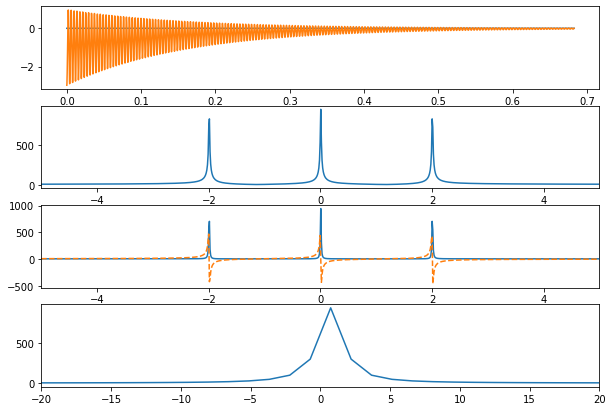

In [5]:
obj = sim.simulator(spinsys,B0)
# Test hard pulse press
pulseDur = 0.15E-3 #0.25 ms
fa = 90
pulseAmp_90 = 500 * (1E-3/pulseDur) * (fa/180)
pulseAmp_180 = 500 * (1E-3/pulseDur) * (180/180)
offset =0
pulsePhase = 0; #radians

steps = 50 #10 us steps
timeStep = pulseDur/steps
pulse90 = np.full(steps,pulseAmp_90)
pulse180 = np.full(steps,pulseAmp_180)

TE1 = 10E-3
TE2 = 10E-3
timeGap1 = TE1/2 - pulseDur #2x half pulse duration
timeGap2 = (TE1/2 - pulseDur/2)+(TE2/2 - pulseDur/2)
timeGap3 = TE2/2 - pulseDur/2
#print(pulseAmp_90/offset)
obj.applyRF(pulse90,timeStep,offset=offset)
obj.selectCoherence(-1)
obj.freeEvolution(timeGap1)
obj.applyRF(pulse180,timeStep,offset=offset)
obj.selectCoherence(1)
obj.freeEvolution(timeGap2)
obj.applyRF(pulse180,timeStep,offset=offset)
obj.selectCoherence(-1)
obj.freeEvolution(timeGap3)
s,ax = obj.readout(4096,1/6000,2)

plt.rcParams['figure.figsize'] = [10, 7]
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4,1)
ax1.plot(ax['time'],np.real(s))
ax1.plot(ax['time'],np.imag(s))
#plt.ylim([-100,100])
phaseCorr = np.exp(1j*(np.pi/180)*90)
spec = phaseCorr*np.fft.fftshift(np.fft.fft(s))
ax2.plot(ax['ppm'],np.abs(spec))
ax3.set_xlim([-5,5])
ax3.plot(ax['ppm'],np.real(spec))
ax3.plot(ax['ppm'],np.imag(spec),'--')
ax2.set_xlim([-5,5])
ax4.plot(ax['freq'],np.real(spec))
ax4.set_xlim([-20,20])

### Check slice selection in 1D

In [957]:
import scipy.io

# Load a real pulse 
matload = scipy.io.loadmat('hsinc_400_8750')
origpulse = matload['hsinc_400_8750_complexAmp']

# Interpolate it to fewer points to reduce calculation time 
pulse = np.interp(np.arange(0,origpulse.shape[0],5), np.arange(0,origpulse.shape[0]), origpulse[:,0])
pulse /= np.max(pulse)
pulse_time=3e-3
pulseSteps = pulse.shape[0]
shapedTimeStep = pulse_time/pulseSteps
print(f'Pulse time = {pulse_time}s, {pulseSteps} steps, {shapedTimeStep} step time')
pulseInt = np.sum(np.real(pulse))/pulseSteps
targetFA = 90
pulse_frq=0
pulse_pwr=500*(targetFA/180)*(1E-3/pulse_time)*(1/pulseInt)

# Calculate the spatially static part of the hamiltonian
H = obj.Hcs+obj.Hj+obj.getHRF(pulse_pwr*pulse,pulse_frq)

# Gradient vector
gradShaped = np.array([0.00343,0,0]) #in T/m

# position vector 
posVec = np.arange(-0.025,0.025,0.001)
posVec = np.stack([posVec,np.zeros(posVec.shape),np.zeros(posVec.shape)],axis=1)

# Loop over position vector
SShaped = []
ADCSteps = 4096;
ADCBW = 6000
ADCDwellTime = 1/ADCBW
FID1DTest = []
for r in posVec:
    ptmp = obj.thermalEq()
    Hg = obj.getHGrad(gradShaped,r)
    ptmp = obj.propagate(H+Hg,shapedTimeStep,p=ptmp)
    ptmp = obj.selectCoherence(-1,p=ptmp)
    fid,ax = obj.readout(ADCSteps,ADCDwellTime,2,p=ptmp)
    FID1DTest.append(fid)

FID1DTest = np.array(FID1DTest).T
spec1DTest = np.fft.fftshift(np.fft.fft(FID1DTest,axis=0),axes=0)

Pulse time = 0.003s, 80 steps, 3.7500000000000003e-05 step time


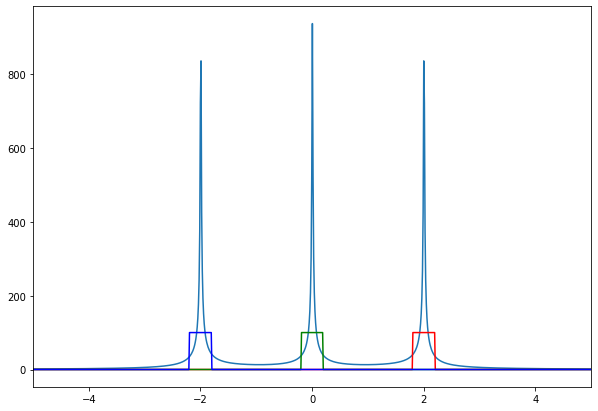

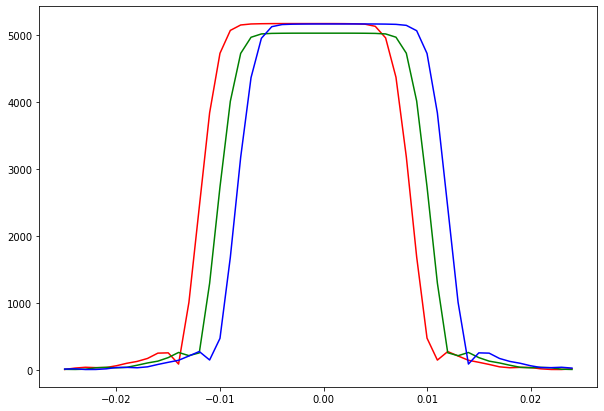

In [960]:
# Plot
ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))

plt.plot(ax['ppm'],np.abs(spec1DTest[:,25]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[0][:,None],axis=0)
peak2Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[1][:,None],axis=0)
peak3Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[2][:,None],axis=0)

plt.plot(posVec[:,0],peak1Sum,'r')
plt.plot(posVec[:,0],peak2Sum,'g')
plt.plot(posVec[:,0],peak3Sum,'b')

plt.show()

## Test full simulator in notebook format

#### List of parameters
Simulator must be passed the follwoing parameters stored as a dict.

##### Required
- B0 - Float. Static field strength in tesla.
- Rx_Points - Int. FID points
- Rx_SW - Float. Reciver sweep width (or bandwidth)
- Rx_LW - Float. Damping applied to final FID signal. Time constant = 1/(pi*Rx_LW)
- Rx_Phase - Float (radians). Constant phase applied to final FID.

- x/y/z - 1 x 2 list of floats. Start and end of spatial extent. Default units are m.
- resolution - 1 x 3 list of int. Resolution of x,y and z dimensions.

- CoherenceFilter - 1x$N_{RF}$ list of ints. Coherence order filter applied after RF and free evolution (+rephase) periods. Only elements of the density matrix with and order matching the value in the list are retained. 'None' applies no filter.

- RF - $N_{RF}$ list of objects containing the following pulse definition fields:
    - amp - List of pulse amplitude values. Default units are Hz.
    - phase - List of pulse phase values. Default units are Hz.  
    *OR*
    - cmplx - List of complex pulse values. Default units are Hz.  
    *And the following required fields:*
    - time - Float. Total pulse time in seconds.
    - grad - 1x3 list of floats. Gradient values during RF on x/y/z. Default units are tesla/m.  
    *And the optional fields:*
    - frequencyOffset - float. Frequency offset of pulse.
    - phaseOffset - float in radians. Fixed additional phase offset.
    - ampScale - float. Scale amplitude of pulse by this amount
    
- delays - 1x$N_{RF}$ list of floats. Free evolution time/rephase time after an RF pulse. In seconds.
- rephaseAreas - $N_{RF}$x3 list of floats. Rephase gradient area on each of the three spatial axes. Default units are Ts/m (tesla seconds per meter).

##### Optional
- RFUnits - String. Hz/T/mT/uT (Hz Default)
- GradUnits - String. mT/T/Hz per m (T default)
- spaceUnits - String. m/cm/mm (m default)
- centralShift - Float in ppm. Chemical shift offset of experiment (Tx/Rx) centre from 0 ppm.
- spatiallyResolve - Bool. If set to True then simulation will output FID for each simulated spatial position. Method will be adjusted accordingly as this is not compatible with '1d'.
- method - String. '1d'/'interleaved'/'full' - Simulation method.


### 1D sequence

In [970]:
import simseq
parameterdict = {}
parameterdict.update({'centralShift':0})
parameterdict.update({'B0':7})

parameterdict.update({'Rx_LW':2})
parameterdict.update({'Rx_SW':6000})
parameterdict.update({'Rx_Points':4096})
parameterdict.update({'Rx_Phase':0})
       
parameterdict.update({'x':(-25,25)})
parameterdict.update({'y':(-0,0)})
parameterdict.update({'z':(-0,0)})
parameterdict.update({'resolution':(25,1,1)})
parameterdict.update({'spaceUnits':'mm'})
    
parameterdict.update({'CoherenceFilter':[-1,]})

pulse1 = {}
pulse1.update({'cmplx':pulse_pwr*pulse})
pulse1.update({'time':pulse_time})
pulse1.update({'grad':[0.00343,0,0]})
pulse1.update({'frequencyOffset':0.0})
pulse1.update({'phaseOffset':0.0})
RFList = [pulse1]
parameterdict.update({'RF':RFList})

rephaseMat = np.zeros((1,3))
rephaseMat[0,0] = -0.00343*pulse_time/2
print(rephaseMat)
parameterdict.update({'rephaseAreas':rephaseMat})
parameterdict.update({'delays':np.array([1.0E-3])})

parameterdict.update({'spatiallyResolve':True})
parameterdict.update({'method':'interleaved'})

spinsys = {'shifts':np.array([0,-2, 2]),'j':np.array([[0,0,0],[0,0,0],[0,0,0]])}

FIDsim1D,ax = simseq.simseq(spinsys,parameterdict)


[[-5.14500e-06  0.00000e+00  0.00000e+00]]
Simulation running using mode interleaved. Axis order = [0].


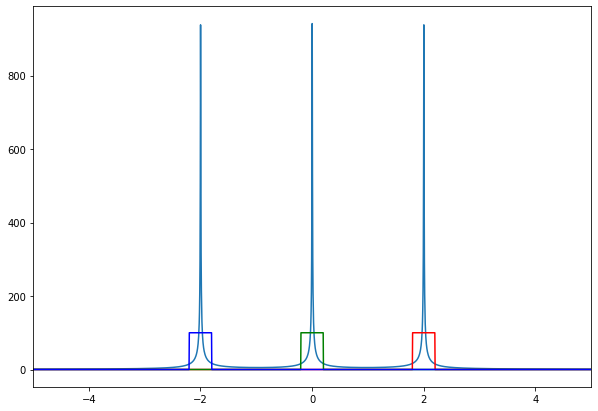

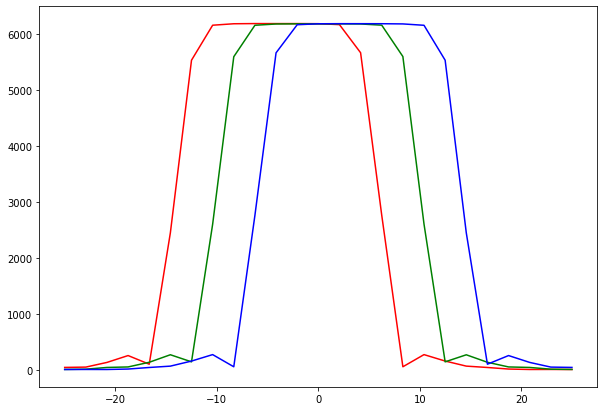

In [972]:
spec1DTest = np.fft.fftshift(np.fft.fft(FIDsim1D,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))

plt.plot(ax['ppm'],np.abs(spec1DTest[:,12,0,0]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[1][:,None,None,None],axis=0)
peak3Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[2][:,None,None,None],axis=0)

pos = np.linspace(parameterdict['x'][0],parameterdict['x'][1],parameterdict['resolution'][0])
plt.plot(pos,peak1Sum[:,0,0],'r')
plt.plot(pos,peak2Sum[:,0,0],'g')
plt.plot(pos,peak3Sum[:,0,0],'b')

plt.show()

### 2D (90+180)

In [973]:
parameterdict = {}
parameterdict.update({'centralShift':0})
parameterdict.update({'B0':7})

parameterdict.update({'Rx_LW':2})
parameterdict.update({'Rx_SW':6000})
parameterdict.update({'Rx_Points':4096})
parameterdict.update({'Rx_Phase':0})
       
parameterdict.update({'x':(-25,25)})
parameterdict.update({'y':(-25,25)})
parameterdict.update({'z':(-0,0)})
parameterdict.update({'resolution':(15,15,1)})
parameterdict.update({'spaceUnits':'mm'})
    
parameterdict.update({'CoherenceFilter':[1,-1]})

pulse1 = {}
pulse1.update({'cmplx':pulse_pwr*pulse})
pulse1.update({'time':pulse_time})
pulse1.update({'grad':[0.00343,0,0]})
pulse1.update({'frequencyOffset':0.0})
pulse1.update({'phaseOffset':0.0})

pulse2 = {}
pulse2.update({'cmplx':pulse_pwr*pulse})
pulse2.update({'time':pulse_time})
pulse2.update({'grad':[0,0.00343,0]})
pulse2.update({'frequencyOffset':0.0})
pulse2.update({'phaseOffset':0.0})
pulse2.update({'ampScale':2.0})

RFList = [pulse1,pulse2]
parameterdict.update({'RF':RFList})

rephaseMat = np.zeros((2,3))
rephaseMat[0,0] = -0.00343*pulse_time/2
parameterdict.update({'rephaseAreas':rephaseMat})
TE = 10E-3
delay1 = TE/2 - pulse_time
delay2 = TE/2 - pulse_time/2
parameterdict.update({'delays':np.array([delay1,delay2])})

parameterdict.update({'spatiallyResolve':True})
parameterdict.update({'method':'interleaved'})

FIDsim2D,ax = simseq.simseq(spinsys,parameterdict)


Simulation running using mode interleaved. Axis order = [0 1].


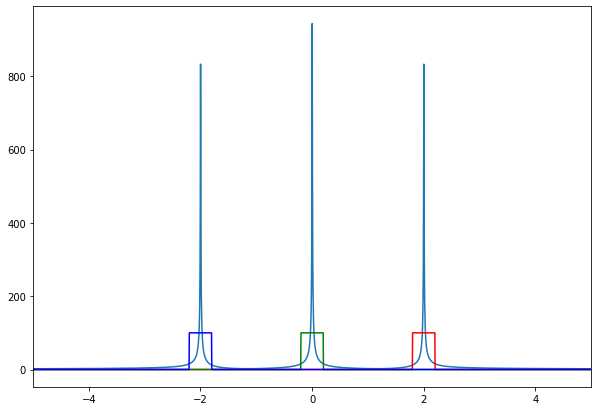

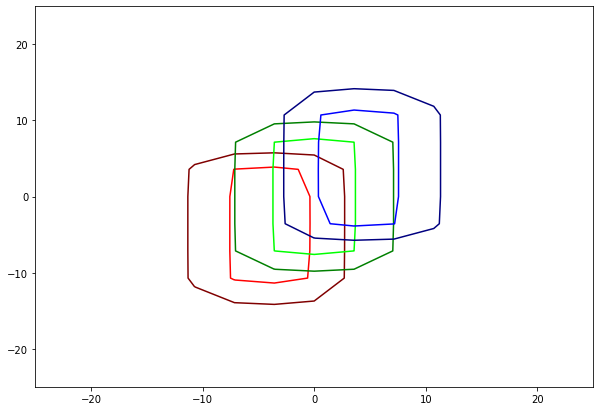

In [975]:
spec2DTest = np.fft.fftshift(np.fft.fft(FIDsim2D,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))

plt.plot(ax['ppm'],np.abs(spec2DTest[:,7,7,0]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec2DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec2DTest)*ppmIndicies[1][:,None,None,None],axis=0)
peak3Sum = np.sum(np.abs(spec2DTest)*ppmIndicies[2][:,None,None,None],axis=0)

peak1Sum /= np.max(peak1Sum)
peak2Sum /= np.max(peak2Sum)
peak3Sum /= np.max(peak3Sum)

pos = np.linspace(parameterdict['x'][0],parameterdict['x'][1],parameterdict['resolution'][0])
pos2 = np.linspace(parameterdict['y'][0],parameterdict['y'][1],parameterdict['resolution'][1])

plt.contour(pos,pos2,peak1Sum[:,:,0],[0.5,0.9],colors=((0.5, 0, 0),(1,0, 0)))
plt.contour(pos,pos2,peak2Sum[:,:,0],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))
plt.contour(pos,pos2,peak3Sum[:,:,0],[0.5,0.9],colors=((0, 0, 0.5),(0,0, 1)))

plt.show()

### 3D (STEAM 90+90+90)

In [977]:
from copy import deepcopy 
parameterdict = {}
parameterdict.update({'centralShift':0})
parameterdict.update({'B0':7})

parameterdict.update({'Rx_LW':2})
parameterdict.update({'Rx_SW':6000})
parameterdict.update({'Rx_Points':4096})
parameterdict.update({'Rx_Phase':0})
       
parameterdict.update({'x':(-25,25)})
parameterdict.update({'y':(-25,25)})
parameterdict.update({'z':(-25,25)})
parameterdict.update({'resolution':(15,15,15)})
parameterdict.update({'spaceUnits':'mm'})
    
parameterdict.update({'CoherenceFilter':[1,0,-1]})

pulse1 = {}
pulse1.update({'cmplx':pulse_pwr*pulse})
pulse1.update({'time':pulse_time})
pulse1.update({'grad':[0.00343,0,0]})
pulse1.update({'frequencyOffset':0.0})
pulse1.update({'phaseOffset':0.0})

pulse2 = deepcopy(pulse1)
pulse3 = deepcopy(pulse1)
pulse2['grad'] = [0,0.00343,0]
pulse3['grad'] = [0,0,0.00343]

RFList = [pulse1,pulse2,pulse3]
parameterdict.update({'RF':RFList})

rephaseMat = np.zeros((3,3))
rephaseMat[0,0] = -0.00343*pulse_time/2
rephaseMat[0,1] = -0.00343*pulse_time/2
rephaseMat[2,2] = -0.00343*pulse_time/2
parameterdict.update({'rephaseAreas':rephaseMat})

TE = 11E-3
TM = 32E-3
TEGap1 = TE/2 - pulse_time
TEGap2 = TE/2 - (pulse_time/2)
TMGap = TM - pulse_time
parameterdict.update({'delays':np.array((TEGap1,TMGap,TEGap2))})

parameterdict.update({'spatiallyResolve':True})
parameterdict.update({'method':'interleaved'})

spinsys = {'shifts':np.array([-2,2]),'j':np.array([[0,0],[0,0]])}

FIDsim3D,ax = simseq.simseq(spinsys,parameterdict)

Simulation running using mode interleaved. Axis order = [0 1 2].


(4096,)
(4096, 25, 1, 1)


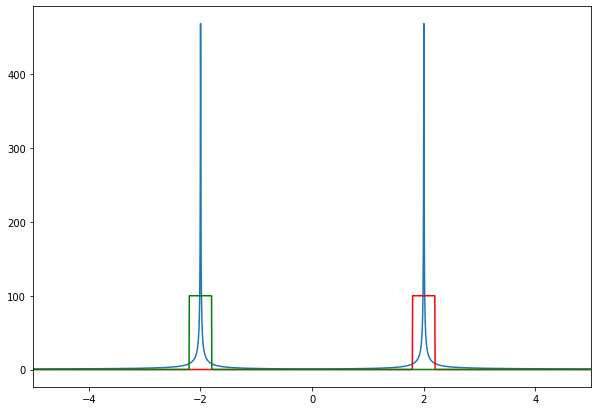

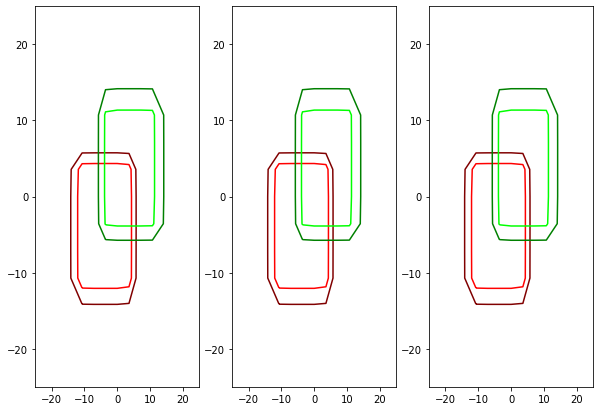

In [978]:
spec3DTest = np.fft.fftshift(np.fft.fft(FIDsim3D,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
#ppmIndicies.append((ax['ppm']<0.6)&(ax['ppm']>0.4))
# ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))
print(ax['ppm'].shape)
print(spec1DTest.shape)
plt.plot(ax['ppm'],np.abs(spec3DTest[:,7,7,7]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
# plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec3DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec3DTest)*ppmIndicies[1][:,None,None,None],axis=0)
# peak3Sum = np.sum(np.abs(spec3DTest)*ppmIndicies[2][:,None,None,None],axis=0)

peak1Sum /= np.max(peak1Sum)
peak2Sum /= np.max(peak2Sum)
peak3Sum /= np.max(peak3Sum)

pos = np.linspace(parameterdict['x'][0],parameterdict['x'][1],parameterdict['resolution'][0])
pos2 = np.linspace(parameterdict['y'][0],parameterdict['y'][1],parameterdict['resolution'][1])
pos3 = np.linspace(parameterdict['z'][0],parameterdict['z'][1],parameterdict['resolution'][2])

fig, (ax1, ax2, ax3)= plt.subplots(1,3)
# ax1.plot(pos,peak1Sum[:,7,7])
# ax1.plot(pos,peak2Sum[:,7,7])
# ax2.plot(pos,peak1Sum[7,:,7])
# ax2.plot(pos,peak2Sum[7,:,7])
# ax3.plot(pos,peak1Sum[7,7,:])
# ax3.plot(pos,peak2Sum[7,7,:])

ax1.contour(pos,pos2,peak1Sum[:,:,7],[0.5,0.8],colors=((0.5, 0, 0),(1,0, 0)))
ax1.contour(pos,pos2,peak2Sum[:,:,7],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))
# ax1.contour(pos,pos2,peak3Sum[:,:,5],[0.5,0.9],colors=((0, 0, 0.5),(0,0, 1)))

ax2.contour(pos,pos3,peak1Sum[:,7,:],[0.5,0.8],colors=((0.5, 0, 0),(1,0, 0)))
ax2.contour(pos,pos3,peak2Sum[:,7,:],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))
# ax2.contour(pos,pos3,peak3Sum[:,5,:],[0.5,0.9],colors=((0, 0, 0.5),(0,0, 1)))

ax3.contour(pos2,pos3,peak1Sum[7,:,:],[0.5,0.8],colors=((0.5, 0, 0),(1,0, 0)))
ax3.contour(pos2,pos3,peak2Sum[7,:,:],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))
# ax3.contour(pos2,pos3,peak3Sum[5,:,:],[0.5,0.9],colors=((0, 0, 0.5),(0,0, 1)))

### 3D (PRESS 90+180+180)

In [979]:
parameterdict = {}
parameterdict.update({'centralShift':0})
parameterdict.update({'B0':7})

parameterdict.update({'Rx_LW':2})
parameterdict.update({'Rx_SW':6000})
parameterdict.update({'Rx_Points':4096})
parameterdict.update({'Rx_Phase':0})
       
parameterdict.update({'x':(-25,25)})
parameterdict.update({'y':(-25,25)})
parameterdict.update({'z':(-25,25)})
parameterdict.update({'resolution':(15,15,15)})
parameterdict.update({'spaceUnits':'mm'})
    
parameterdict.update({'CoherenceFilter':[-1,1,-1]})

pulse1 = {}
pulse1.update({'cmplx':pulse_pwr*pulse})
pulse1.update({'time':pulse_time})
pulse1.update({'grad':[0.00343,0,0]})
pulse1.update({'frequencyOffset':0.0})
pulse1.update({'phaseOffset':0.0})

pulse2 = {}
pulse2.update({'cmplx':pulse_pwr*pulse})
pulse2.update({'time':pulse_time})
pulse2.update({'grad':[0,0.00343,0]})
pulse2.update({'frequencyOffset':0.0})
pulse2.update({'phaseOffset':0.0})
pulse2.update({'ampScale':2.0})

pulse3 = deepcopy(pulse2)
pulse3['grad'] = [0,0,0.00343]

RFList = [pulse1,pulse2,pulse3]
parameterdict.update({'RF':RFList})

rephaseMat = np.zeros((3,3))
rephaseMat[0,0] = -0.00343*pulse_time/2
parameterdict.update({'rephaseAreas':rephaseMat})

TE1 = 10E-3
TE2 = 10E-3
TEGap1 = TE1/2 - pulse_time
TEGap2 = TE1/2 + TE2/2 - pulse_time
TEGap3 = TE2/2 - (pulse_time/2)
parameterdict.update({'delays':np.array((TEGap1,TEGap2,TEGap3))})

parameterdict.update({'spatiallyResolve':True})
parameterdict.update({'method':'interleaved'})

spinsys = {'shifts':np.array([-2,2]),'j':np.array([[0,0],[0,0]])}

FIDsim3D2,ax = simseq.simseq(spinsys,parameterdict)

Simulation running using mode interleaved. Axis order = [0 1 2].


(4096,)
(4096, 25, 1, 1)


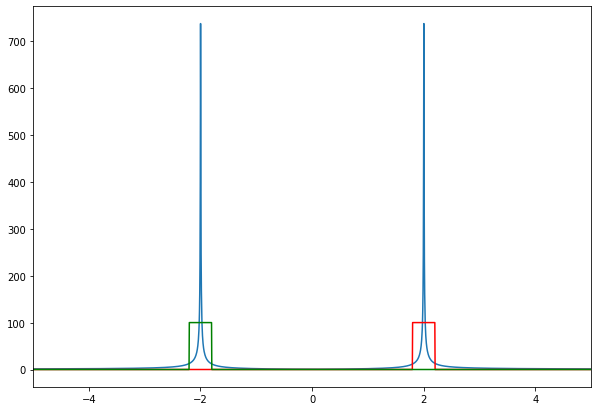

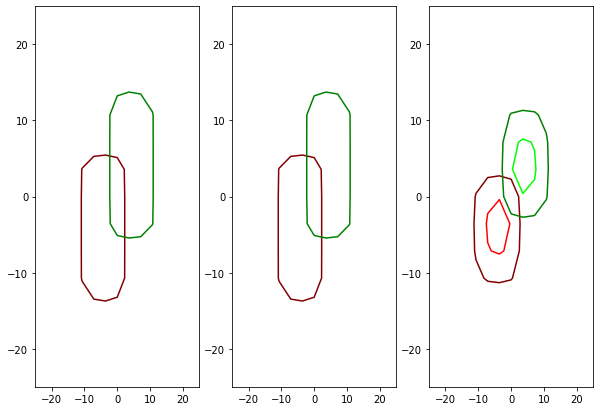

In [980]:
spec3DTest = np.fft.fftshift(np.fft.fft(FIDsim3D2,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
#ppmIndicies.append((ax['ppm']<0.6)&(ax['ppm']>0.4))
# ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))
print(ax['ppm'].shape)
print(spec1DTest.shape)
plt.plot(ax['ppm'],np.abs(spec3DTest[:,7,7,7]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
# plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec3DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec3DTest)*ppmIndicies[1][:,None,None,None],axis=0)
# peak3Sum = np.sum(np.abs(spec3DTest)*ppmIndicies[2][:,None,None,None],axis=0)

peak1Sum /= np.max(peak1Sum)
peak2Sum /= np.max(peak2Sum)
peak3Sum /= np.max(peak3Sum)

pos = np.linspace(parameterdict['x'][0],parameterdict['x'][1],parameterdict['resolution'][0])
pos2 = np.linspace(parameterdict['y'][0],parameterdict['y'][1],parameterdict['resolution'][1])
pos3 = np.linspace(parameterdict['z'][0],parameterdict['z'][1],parameterdict['resolution'][2])

fig, (ax1, ax2, ax3)= plt.subplots(1,3)
# ax1.plot(pos,peak1Sum[:,7,7])
# ax1.plot(pos,peak2Sum[:,7,7])
# ax2.plot(pos,peak1Sum[7,:,7])
# ax2.plot(pos,peak2Sum[7,:,7])
# ax3.plot(pos,peak1Sum[7,7,:])
# ax3.plot(pos,peak2Sum[7,7,:])
ax1.contour(pos,pos2,peak1Sum[:,:,7],[0.5,0.9],colors=((0.5, 0, 0),(1,0, 0)))
ax1.contour(pos,pos2,peak2Sum[:,:,7],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))

ax2.contour(pos,pos3,peak1Sum[:,7,:],[0.5,0.9],colors=((0.5, 0, 0),(1,0, 0)))
ax2.contour(pos,pos3,peak2Sum[:,7,:],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))

ax3.contour(pos2,pos3,peak1Sum[7,:,:],[0.5,0.9],colors=((0.5, 0, 0),(1,0, 0)))
ax3.contour(pos2,pos3,peak2Sum[7,:,:],[0.5,0.9],colors=((0, 0.5, 0),(0,1, 0)))


## Compare the three simulation methods 
1D projection  
Interleaved  
Full  

In [982]:
parameterdict = {}
parameterdict.update({'centralShift':0})
parameterdict.update({'B0':7})

parameterdict.update({'Rx_LW':2})
parameterdict.update({'Rx_SW':6000})
parameterdict.update({'Rx_Points':4096})
parameterdict.update({'Rx_Phase':np.pi/2})
       
parameterdict.update({'x':(-25,25)})
parameterdict.update({'y':(-25,25)})
parameterdict.update({'z':(-25,25)})
parameterdict.update({'resolution':(11,11,11)})
parameterdict.update({'spaceUnits':'mm'})
    
parameterdict.update({'CoherenceFilter':[1,0,-1]})

pulse1 = {}
pulse1.update({'cmplx':pulse_pwr*pulse})
pulse1.update({'time':pulse_time})
pulse1.update({'grad':[0.00343,0,0]})
pulse1.update({'frequencyOffset':0.0})
pulse1.update({'phaseOffset':0.0})

pulse2 = deepcopy(pulse1)
pulse3 = deepcopy(pulse1)
pulse2['grad'] = [0,0.00343,0]
pulse3['grad'] = [0,0,0.00343]

RFList = [pulse1,pulse2,pulse3]
parameterdict.update({'RF':RFList})

rephaseMat = np.zeros((3,3))
rephaseMat[0,0] = -0.00343*pulse_time/2
rephaseMat[0,1] = -0.00343*pulse_time/2
rephaseMat[2,2] = -0.00343*pulse_time/2
parameterdict.update({'rephaseAreas':rephaseMat})

TE = 11E-3
TM = 32E-3
TEGap1 = TE/2 - pulse_time
TEGap2 = TE/2 - (pulse_time/2)
TMGap = TM - pulse_time
parameterdict.update({'delays':np.array((TEGap1,TMGap,TEGap2))})

parameterdict.update({'spatiallyResolve':False})

spinsys = {'shifts':np.array([0,2, -1]),'j':np.array([[0,0,10],[0,0,0],[10,0,0]])}

parameterdict.update({'method':'1D'})
# %timeit -n 1 -r 1 FID,ax = simseq.simseq(spinsys,parameterdict)
FID,ax = simseq.simseq(spinsys,parameterdict)
parameterdict.update({'method':'interleaved'})
# %timeit -n 1 -r 1 FIDInter,ax = simseq.simseq(spinsys,parameterdict)
FIDInter,ax = simseq.simseq(spinsys,parameterdict)
parameterdict.update({'method':'full'})
# %timeit -n 1 -r 1 FIDFull,ax = simseq.simseq(spinsys,parameterdict)
FIDFull,ax = simseq.simseq(spinsys,parameterdict)

Simulation running using mode 1d. Axis order = [0 1 2].
Simulation running using mode interleaved. Axis order = [0 1 2].
Simulation running using mode full. Axis order = [0 1 2].


(-2.5, 4)

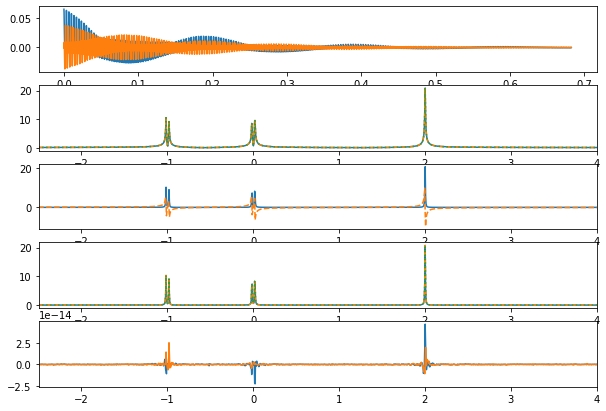

In [983]:
fig, (ax1, ax2, ax3, ax4 ,ax5)= plt.subplots(5,1)
ax1.plot(ax['time'],np.real(FID))
ax1.plot(ax['time'],np.imag(FID))
#plt.ylim([-100,100])
phaseCorr = np.exp(1j*(np.pi/180)*0)
spec = np.fft.fftshift(np.fft.fft(FID))
spec2 = phaseCorr*np.fft.fftshift(np.fft.fft(FIDInter))
spec3 = phaseCorr*np.fft.fftshift(np.fft.fft(FIDFull))
ax2.plot(ax['ppm'],np.abs(spec))
ax2.plot(ax['ppm'],np.abs(spec2),'--')
ax2.plot(ax['ppm'],np.abs(spec3),':')
ax3.set_xlim([-2.5,4])
ax3.plot(ax['ppm'],np.real(spec))
ax3.plot(ax['ppm'],np.imag(spec),'--')
ax2.set_xlim([-2.5,4])
ax4.plot(ax['ppm'],np.real(spec))
ax4.plot(ax['ppm'],np.real(spec2),'--')
ax4.plot(ax['ppm'],np.real(spec3),':')
ax4.set_xlim([-2.5,4])
ax5.plot(ax['ppm'],np.real(spec)-np.real(spec2))
ax5.plot(ax['ppm'],np.real(spec)-np.real(spec3))
ax5.set_xlim([-2.5,4])